In [1]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd
import re

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon

from attwizard.script.utils import read_data_in_parallel
from attwizard.script.utils import load_json_file

# EDA
from attwizard.visualizer.eda import visualize_corr_vs
from attwizard.visualizer.eda import visualize_code_heatmap_codegen
from attwizard.visualizer.eda import plot_histogram_in_parallel

from pandarallel import pandarallel
from attwizard.visualizer.eda import plot_100_perc_stacked_bar

This file reproduces the plots obtained in the paper. The results are presented in the following order:
1. Answer correctness
2. Agreement on visual attention (token-level): CodeGen, GPT-J, Incoder, Developers
3. Agreement on visual attention for different pairs of performance metrics: human vs models. (e.g. do they agree more when they are both right? or what is the agreement when they are both wrong?)
4. Agreement on interaction matrix 
    - CodeGen vs Ground truth
    - GPT-j vs Ground truth
    - Incoder vs Ground truth
5. Ablation study on the followup attention


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
OUT_PAPER_FOLDER = "../data/paper_figures/rebuttal"
#MASTER_DATA_FOLDER = "../data/iclr2023data"


#PATH_DATASET_COMPARISONS = os.path.join(MASTER_DATA_FOLDER, "df_codegen_comparisons_and_abl_study.csv")
#PATH_METADATA_TIME_SPENT_ON_TOKENS = os.path.join(MASTER_DATA_FOLDER, "metadata_developers_time_spent_on_codegen_tokens")

# Comparisons DATA
COMPARISON_FOLDER_CODEGEN = "../data/comparisons/cmp_v06/codegen_rebuttal"
COMPARISON_FOLDER_GPTJ = "../data/comparisons/cmp_v06/gptj_rebuttal"
COMPARISON_FOLDER_INCODER = "../data/comparisons/cmp_v06/incoder_rebuttal"
COMPARISON_FOLDER_CODEGEN6B = "../data/comparisons/cmp_v06/codegen6B_rebuttal"
COMPARISON_VECTORS_FOLDERS = [COMPARISON_FOLDER_CODEGEN, COMPARISON_FOLDER_GPTJ, COMPARISON_FOLDER_INCODER, COMPARISON_FOLDER_CODEGEN6B]
COMPARISON_VECTORS_MODEL_NAMES = [
    "codegen",
    "gptj",
    "incoder",
    "codegen6B"
]

# VISUAL COMPARISON CSVs
COMPARISON_NAMES = [
    'plain_weights_humans.csv', 
    'plain_weights_meanfollowers.csv', 
    'plain_weights_mean_meanfollowers.csv',
    'plain_weights_tokens_at_least_a_letter_humans.csv', 
    'plain_weights_tokens_at_least_a_letter_meanfollowers.csv', 
    'plain_weights_tokens_at_least_a_letter_mean_meanfollowers.csv']

# INTERACTION MATRIX - COMPARISONS CSVs
COMPARISONS_INTERACTION_MATRIX = [
    'tl_spearman_divide_all_dist_copycat.csv',
    'tl_spearman_divide_all_dist_followup.csv',
    'tl_spearman_divide_all_dist_gauss_neigh_1000.csv',
    'tl_spearman_divide_all_dist_humans.csv',
    'tl_spearman_divide_all_dist_naivemax.csv',
    'tl_spearman_divide_all_dist_naivemax_sym.csv',
    'tl_spearman_divide_all_dist_naivemean.csv',
    'tl_spearman_divide_all_dist_naivemean_sym.csv',
    'tl_spearman_divide_all_dist_raw_weights_first_layer.csv',
    'tl_spearman_divide_all_dist_raw_weights_first_layer_sym.csv',
    'tl_spearman_divide_all_dist_raw_weights_last_layer.csv',
    'tl_spearman_divide_all_dist_raw_weights_last_layer_sym.csv',
    'tl_spearman_divide_all_dist_rollout_condensed_all.csv',
    'tl_spearman_divide_all_dist_uniform.csv',
    'tl_top3_divide_all_dist_copycat.csv',
    'tl_top3_divide_all_dist_followup.csv',
    'tl_top3_divide_all_dist_gauss_neigh_1000.csv',
    'tl_top3_divide_all_dist_humans.csv',
    'tl_top3_divide_all_dist_naivemax.csv',
    'tl_top3_divide_all_dist_naivemax_sym.csv',
    'tl_top3_divide_all_dist_naivemean.csv',
    'tl_top3_divide_all_dist_naivemean_sym.csv',
    'tl_top3_divide_all_dist_raw_weights_first_layer.csv',
    'tl_top3_divide_all_dist_raw_weights_first_layer_sym.csv',
    'tl_top3_divide_all_dist_raw_weights_last_layer.csv',
    'tl_top3_divide_all_dist_raw_weights_last_layer_sym.csv',
    'tl_top3_divide_all_dist_rollout_condensed_all.csv',
    'tl_top3_divide_all_dist_uniform.csv'
]
    

# ANNOTATION - ACCURACY 
CODEGEN_ANNOTATIONS = "../data/annotations/2022-09-18/Answer Evaluation - Users - CODEGEN_SCORE.csv"
GPTJ_ANNOTATIONS = "../data/annotations/2022-09-18/Answer Evaluation - Users - GPTJ_SCORE.csv"
INCODER_ANNOTATIONS = "../data/annotations/2022-11-11/Answer Evaluation - Users - INCODER_SCORE.csv"
HUMAN_ANNOTATIONS = "../data/annotations/2022-09-18/Answer Evaluation - Users - HUMAN_SCORE.csv"

# HUMAN ATTENTION ON MODEL-SPECIFIC TOKENS
TIME_SPENT_ON_TOKENS_METADATA_FOLDERS = [
    "../data/eye_tracking_attention/eye_v10/att_weights_Salesforce_codegen-16B-multi/metadata/",
    "../data/eye_tracking_attention/eye_v10/att_weights_EleutherAI_gpt-j-6B/metadata/",
    "../data/eye_tracking_attention/eye_v10/att_weights_facebook_incoder-6B/metadata/",
    "../data/eye_tracking_attention/eye_v10/att_weights_Salesforce_codegen-6B-multi/metadata/"
]
MODEL_NAMES = [
    "codegen",
    "gptj",
    "incoder",
    "codegen6B"
]

In [4]:
dict_df_tokens_w_time = {}

# the maximum allowed replication of each record, even if the token is looked
# at for a long time
MAX_TIME_WEIGHT = 10

for metadata_folder, model_name in zip(TIME_SPENT_ON_TOKENS_METADATA_FOLDERS, MODEL_NAMES):
    print("model_name: ", model_name)
    # LOAD THE TOKEN INFORMATION
    tokens_metdata = read_data_in_parallel(
        base_folder=metadata_folder,
        file_type_extension='.json',
        read_function=load_json_file
    )
    all_tokens = [v for k, v in tokens_metdata.items()]
    # flattent the list
    all_tokens = [item for sublist in all_tokens for item in sublist]
    df_tokens = pd.DataFrame.from_records(all_tokens)
    # compute the total time spent in each session to normalize the weights
    df_total_times = df_tokens.groupby('id').agg({'w': 'sum'}).reset_index()
    df_total_times.rename(columns={'w': 'total_time'}, inplace=True)
    # join the two tables and compute the percentage of total time with column w and column total_time
    df_tokens_w_time = df_tokens.merge(df_total_times, on='id')
    df_tokens_w_time['n_replicas_abs'] = df_tokens_w_time['w'].astype(int)
    df_tokens_w_time['perc_time'] = df_tokens_w_time['w'] / df_tokens_w_time['total_time']
    df_tokens_w_time['n_replicas_perc'] = df_tokens_w_time['perc_time'].apply(
        lambda x: round(x * 1000))
    # rename the columns to join
    df_tokens_w_time.rename(columns={
        'id': 'input_human_filestem',
        'i': 'token_index'}, inplace=True)
    df_tokens_w_time['percn_replicas_abs'] = df_tokens_w_time['n_replicas_abs'].apply(
        lambda x: min(x, MAX_TIME_WEIGHT))
    print("Dataset with time spent on tokens loaded. It has ", len(df_tokens_w_time), "records")
    df_tokens_w_time["model_name"] = model_name
    dict_df_tokens_w_time[model_name] = df_tokens_w_time

model_name:  codegen
n of data read:  92
Dataset with time spent on tokens loaded. It has  49929 records
model_name:  gptj
n of data read:  92
Dataset with time spent on tokens loaded. It has  77096 records
model_name:  incoder
n of data read:  92
Dataset with time spent on tokens loaded. It has  33725 records
model_name:  codegen6B
n of data read:  92
Dataset with time spent on tokens loaded. It has  49929 records


In [5]:
# READ DATA
#df_codegen = pd.read_csv(PATH_DATASET_COMPARISONS)

In [6]:
df_codegen_score = pd.read_csv(CODEGEN_ANNOTATIONS)
df_human_score = pd.read_csv(HUMAN_ANNOTATIONS)
df_gptj_score = pd.read_csv(GPTJ_ANNOTATIONS)
df_incoder_score = pd.read_csv(INCODER_ANNOTATIONS)

# rename filename to unique_data_id
df_codegen_score = df_codegen_score.rename(columns={"filename": "unique_data_id"})
# extract the filename
# tree_Q3.py_0_Salesforce_codegen-16B-multi --> tree_Q3.py
df_codegen_score["filename"] = df_codegen_score["unique_data_id"].apply(
    lambda x: re.findall(r"(.*)_[0-9]+_Salesforce_codegen-[0-9]+", x)[0]
)
# rename column model_name --> provenance
# rename column n_try --> user
df_codegen_score = df_codegen_score.rename(columns={
    "model_name": "provenance",
    "n_try": "user"})
df_codegen_score["provenance"] = "CodeGen"

# rename filename to unique_data_id
df_gptj_score = df_gptj_score.rename(columns={"filename": "unique_data_id"})
df_gptj_score["filename"] = df_gptj_score["unique_data_id"].apply(
    lambda x: re.findall(r"(.*)_[0-9]+_EleutherAI_gpt-j-6B", x)[0]
)
# rename column model_name --> provenance
# rename column n_try --> user
df_gptj_score = df_gptj_score.rename(columns={
    "model_name": "provenance",
    "n_try": "user"})
df_gptj_score["provenance"] = "Gpt-j"

# rename filename to unique_data_id
df_incoder_score = df_incoder_score.rename(columns={"filename": "unique_data_id"})
df_incoder_score["filename"] = df_incoder_score["unique_data_id"].apply(
    lambda x: re.findall(r"(.*)_[0-9]+_facebook_incoder-6B+", x)[0]
)
# rename column model_name --> provenance
# rename column n_try --> user
df_incoder_score = df_incoder_score.rename(columns={
    "model_name": "provenance",
    "n_try": "user"})
df_incoder_score["provenance"] = "Incoder"


# keep columns: user, filename, score, unique_data_id
df_human_score = df_human_score[["user", "filename", "score", "unique_data_id"]]
# add provenance with human 
df_human_score["provenance"] = "Developers"

# concatenate the two dataframes
df_score = pd.concat([df_human_score, df_gptj_score, df_codegen_score, df_incoder_score], axis=0)
print(len(df_score))
replacement_dict = {
    0: "Wrong",
    1: "Partial",
    2: "Correct",
}
df_score["score"] = df_score["score"].replace(replacement_dict)
df_score.head()

497


,user,filename,score,unique_data_id,provenance
0,UbeerU,multithread_Q2.py,Wrong,d41dd8,Developers
1,UpassionU,hannoi_Q3.cs,Correct,6695fa,Developers
2,UcamelionU,hannoi_Q1.py,Correct,5403f5,Developers
3,UsleepU,hannoi_Q2.py,Correct,0d7601,Developers
4,UscoopU,triangle_Q3.cs,Partial,f936ca,Developers


In [7]:
# LOAD COMPARISON DATA

dict_df_comparison_vectors = {}

for model_name, comparison_folder in zip(COMPARISON_VECTORS_MODEL_NAMES, COMPARISON_VECTORS_FOLDERS):
    print("Loading comparison vectors for model ", model_name)
    dfs = []
    for comparison in tqdm(COMPARISON_NAMES):
        df = pd.read_csv(os.path.join(comparison_folder, comparison))
        dfs.append(df)
    df_vectors = pd.concat(dfs)
    print("Loaded: ", df_vectors["comparison_name"].unique())
    df_vectors["model_name"] = model_name
    dict_df_comparison_vectors[model_name] = df_vectors


Loading comparison vectors for model  codegen


100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


Loaded:  ['plain_weights_humans' 'plain_weights_meanfollowers'
 'plain_weights_mean_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_humans'
 'plain_weights_tokens_at_least_a_letter_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_mean_meanfollowers']
Loading comparison vectors for model  gptj


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Loaded:  ['plain_weights_humans' 'plain_weights_meanfollowers'
 'plain_weights_mean_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_humans'
 'plain_weights_tokens_at_least_a_letter_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_mean_meanfollowers']
Loading comparison vectors for model  incoder


100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


Loaded:  ['plain_weights_humans' 'plain_weights_meanfollowers'
 'plain_weights_mean_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_humans'
 'plain_weights_tokens_at_least_a_letter_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_mean_meanfollowers']
Loading comparison vectors for model  codegen6B


100%|██████████| 6/6 [00:01<00:00,  4.46it/s]

Loaded:  ['plain_weights_humans' 'plain_weights_meanfollowers'
 'plain_weights_mean_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_humans'
 'plain_weights_tokens_at_least_a_letter_meanfollowers'
 'plain_weights_tokens_at_least_a_letter_mean_meanfollowers']


In [11]:
# LOAD COMPARIOSN - INTERACTIOn MATRIX
dict_df_cmparison_interaction_matrix = {}

model_dfs = []

for model_name, comparison_folder in zip(COMPARISON_VECTORS_MODEL_NAMES, COMPARISON_VECTORS_FOLDERS):
    print("Loading comparison INTERACTION MATRICES for model ", model_name)
    # LOAD COMPARISON DATA
    dfs = read_data_in_parallel(
        base_folder=comparison_folder,
        file_type_extension='.csv',
        read_function=pd.read_csv,
        n_processes=20,
        extra_filter_regex='|'.join(COMPARISONS_INTERACTION_MATRIX)
    )
    if len(dfs) == 0:
        print("No data loaded for model ", model_name)
        df_inter_matrix = pd.DataFrame()
    else:
        df_inter_matrix = pd.concat(dfs)
        print("Loaded: ", df_inter_matrix["comparison_name"].unique())
    df_inter_matrix["model_name"] = model_name
    dict_df_cmparison_interaction_matrix[model_name] = df_inter_matrix

df_incoder = dict_df_cmparison_interaction_matrix["incoder"]
df_codegen = dict_df_cmparison_interaction_matrix["codegen"]

Loading comparison INTERACTION MATRICES for model  codegen
n of data read:  0
No data loaded for model  codegen
Loading comparison INTERACTION MATRICES for model  gptj
n of data read:  28
Loaded:  ['tl_spearman_divide_all_dist_copycat'
 'tl_spearman_divide_all_dist_followup'
 'tl_spearman_divide_all_dist_gauss_neigh_1000'
 'tl_spearman_divide_all_dist_humans'
 'tl_spearman_divide_all_dist_naivemax'
 'tl_spearman_divide_all_dist_naivemax_sym'
 'tl_spearman_divide_all_dist_naivemean'
 'tl_spearman_divide_all_dist_naivemean_sym'
 'tl_spearman_divide_all_dist_raw_weights_first_layer'
 'tl_spearman_divide_all_dist_raw_weights_first_layer_sym'
 'tl_spearman_divide_all_dist_raw_weights_last_layer'
 'tl_spearman_divide_all_dist_raw_weights_last_layer_sym'
 'tl_spearman_divide_all_dist_rollout_condensed_all'
 'tl_spearman_divide_all_dist_uniform' 'tl_top3_divide_all_dist_copycat'
 'tl_top3_divide_all_dist_followup'
 'tl_top3_divide_all_dist_gauss_neigh_1000'
 'tl_top3_divide_all_dist_humans' 't

# 0. Auxiliary functions

In [12]:
pandarallel.initialize(progress_bar=False)

def enrich_with_time_weights(df, df_tokens_w_time, short_col_name: str):
    """Add the column telling how long a human spent on a FROM token"""
    # enrich the dataset with the token position and replicate the 
    # records depending on how much time the user spent on that starting
    # token
    df_tokens_w_time_copy = df_tokens_w_time
    df_tokens_w_time_copy = df_tokens_w_time_copy.rename(columns={
        'input_human_filestem': 'unified_input_human_filestem',
        'token_index': f'{short_col_name}.token_index'})
    # check that human_a is not null
    df['unified_input_human_filestem'] = df.parallel_apply(
        lambda row: row['human_a'] 
            if ('human_a' in row.keys() and row['human_a'] is not None and not pd.isna(row['human_a']))
            else row['input_human_filestem'],
        axis=1
    )
    df = df.merge(
        df_tokens_w_time_copy,
        on=['unified_input_human_filestem', f'{short_col_name}.token_index'], 
        how='left')
    return df


def replicated_based_on_weights(df, weight_column_name: str):
    """Replicate the records based on the weight column"""
    df = df.reset_index(drop=True)
    # repeat the rows based on the integer weight contained in the column
    # weights_column_name
    df = df.reindex(df.index.repeat(df[weight_column_name]))
    df = df.reset_index(drop=True)
    #df = df.loc[
    #    np.repeat(df.index.values, df[weight_column_name])]
    return df


def replicated_based_on_token_visibility(
        df, 
        df_tokens_w_time,
        short_col_name: str,
        weight_column_name: str):
    """Replicate the records based on the weight column"""
    df = enrich_with_time_weights(df, df_tokens_w_time, short_col_name)
    df = replicated_based_on_weights(df, weight_column_name)
    return df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# 1. Answer correctness

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


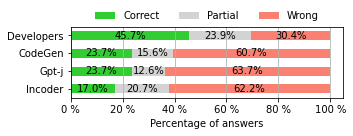

In [14]:
fig, ax = plot_100_perc_stacked_bar(
    df=df_score,
    col_name_group="provenance",
    col_name_category_in_group="score",
    group_order=["Incoder", "Gpt-j", "CodeGen", "Developers"],
    direction="horizontal",
    color=["limegreen", "lightgrey", "salmon"],
    fmt="{:.1%}"
)
# change size 
fig.set_size_inches(5, 2)
# remove ylabel
ax.set_ylabel("")
ax.set_xlabel("Percentage of answers")
plt.tight_layout()

plt.savefig(os.path.join(OUT_PAPER_FOLDER, "RQ1_correctness.pdf"))


## Per Question Breakdown

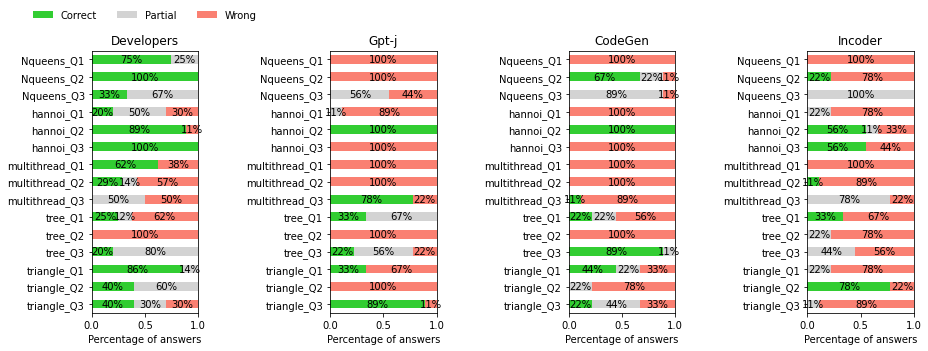

In [69]:
fig, axes = plt.subplots(1, 4, figsize=(13, 5))
for i, provenance in enumerate(["Developers", "Gpt-j", "CodeGen", "Incoder"]):
    df_tmp = df_score[df_score["provenance"] == provenance].copy()
    df_tmp["filename_pl_agnostic"] = df_tmp["filename"].apply(
        lambda x: x.split(".")[0])
    fig, ax = plot_100_perc_stacked_bar(
        df=df_tmp,
        col_name_group="filename_pl_agnostic",
        col_name_category_in_group="score",
        group_order=list(sorted(df_tmp["filename_pl_agnostic"].unique(), reverse=True)),
        direction="horizontal",
        convert_x_to_perc=False,
        color=["limegreen", "lightgrey", "salmon"],
        ax=axes[i],
    )
    ax.set_ylabel("")
    ax.set_title(provenance)
    ax.set_xlabel("Percentage of answers")
    ax.set_xlim(0, 1)
# remove legend 
axes[1].legend().remove()
axes[2].legend().remove()
axes[3].legend().remove()
axes[0].legend(
    bbox_to_anchor=(0.5, 1.1),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)

plt.tight_layout()
fig.savefig(os.path.join(OUT_PAPER_FOLDER, "RQ1_correctness_per_task.pdf"), bbox_inches="tight")

# 2. Agreement on visual attention: CodeGen, GPT-J, Developers

In [8]:
df_codegen_vectors = dict_df_comparison_vectors["codegen"]
df_gptj_vectors = dict_df_comparison_vectors["gptj"]
df_incoder_vectors = dict_df_comparison_vectors["incoder"]
df_codegen6B_vectors = dict_df_comparison_vectors["codegen6B"]

vector_comparisons_chars = [
    {
        "long": "Developers vs Model (CodeGen) - Max",
        'data': df_codegen_vectors[df_codegen_vectors["comparison_name"] == "plain_weights_meanfollowers"],
        'color': 'lightblue'
    },
    {
        "long": "Developers vs Model (Gpt-j) - Max",
        'data': df_gptj_vectors[df_gptj_vectors["comparison_name"] == "plain_weights_meanfollowers"],
        'color': 'lightblue'
    },
    {
        "long": "Developers vs Model (InCoder) - Max",
        'data': df_incoder_vectors[df_incoder_vectors["comparison_name"] == "plain_weights_meanfollowers"],
        'color': 'lightblue'
    },
    {
        "long": "Developers vs Model (CodeGen 6B) - Max",
        'data': df_codegen6B_vectors[df_codegen6B_vectors["comparison_name"] == "plain_weights_meanfollowers"],
        'color': 'lightblue'
    },
    {
        "long": "Developers vs Developers ",
        "data": df_gptj_vectors[df_gptj_vectors["comparison_name"] == "plain_weights_humans"],
        'color': 'lime'
    },
]


vector_comparisons_tokens = [
    {
        "long": "Developers vs Model (CodeGen) - Max",
        'data': df_codegen_vectors[df_codegen_vectors["comparison_name"] == "plain_weights_tokens_at_least_a_letter_meanfollowers"],
        'color': 'lightblue'
    },
    # {
    #     "long": "Developers vs Model (CodeGen) - Mean",
    #     'data': df_codegen_vectors[df_codegen_vectors["comparison_name"] == "plain_weights_tokens_at_least_a_letter_mean_meanfollowers"],
    #     'color': 'royalblue'
    # },
    {
        "long": "Developers vs Model (Gpt-j) - Max",
        'data': df_gptj_vectors[df_gptj_vectors["comparison_name"] == "plain_weights_tokens_at_least_a_letter_meanfollowers"],
        'color': 'lightblue'
    },
    # {
    #     "long": "Developers vs Model (Gpt-j) - Mean",
    #     'data': df_gptj_vectors[df_gptj_vectors["comparison_name"] == "plain_weights_tokens_at_least_a_letter_mean_meanfollowers"],
    #     'color': 'royalblue'
    # },
    {
        "long": "Developers vs Model (InCoder) - Max",
        'data': df_incoder_vectors[df_incoder_vectors["comparison_name"] == "plain_weights_tokens_at_least_a_letter_meanfollowers"],
        'color': 'lightblue'
    },
    # {
    #     "long": "Developers vs Model (InCoder) - Mean",
    #     'data': df_incoder_vectors[df_incoder_vectors["comparison_name"] == "plain_weights_tokens_at_least_a_letter_mean_meanfollowers"],
    #     'color': 'royalblue'
    # },
    {
        "long": "Developers vs Model (CodeGen 6B) - Max",
        'data': df_codegen6B_vectors[df_codegen6B_vectors["comparison_name"] == "plain_weights_tokens_at_least_a_letter_meanfollowers"],
        'color': 'lightblue'
    },
    {
        "long": "Developers vs Developers ",
        "data": df_gptj_vectors[df_gptj_vectors["comparison_name"] == "plain_weights_tokens_at_least_a_letter_humans"],
        'color': 'lime'
    },
]

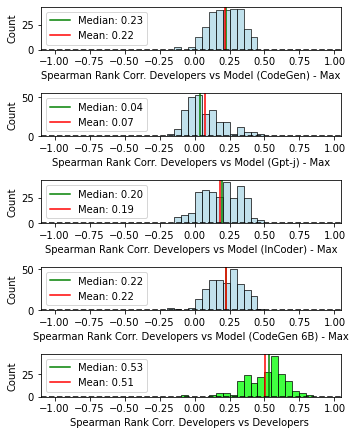

In [9]:
plot_histogram_in_parallel(
    vector_comparisons_chars,
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    vertical_zero_line=True, 
    out_path=os.path.join(OUT_PAPER_FOLDER, "human_vs_models_vector_agreement_chars.pdf"),
)

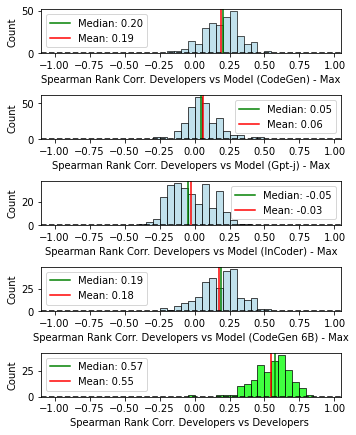

In [10]:
plot_histogram_in_parallel(
    vector_comparisons_tokens,
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    vertical_zero_line=True, 
    out_path=os.path.join(OUT_PAPER_FOLDER, "human_vs_models_vector_agreement_tokens.pdf"),
)

# 3. Agreement on Interaction Matrix

In [13]:
# Naming conversion
naming_mapping = {
 '_divide_all_dist_copycat': 'Copy-cat',
 '_divide_all_dist_followup': 'Follow-up att.',
 '_divide_all_dist_gauss_neigh_1000': 'Position',
 '_divide_all_dist_humans': 'Devs vs devs',
 '_divide_all_dist_naivemax': 'Max att.',
 '_divide_all_dist_naivemax_sym': 'Max att. (sym.)',
 '_divide_all_dist_naivemean': 'Mean att.',
 '_divide_all_dist_naivemean_sym': 'Mean att. (sym.)',
 '_divide_all_dist_raw_weights_first_layer': 'Raw att. (1st layer)',
 '_divide_all_dist_raw_weights_last_layer': 'Raw att. (last layer)',
 '_divide_all_dist_raw_weights_first_layer_sym': 'Raw att. (1st) (sym.)',
 '_divide_all_dist_raw_weights_last_layer_sym': 'Raw att. (last) (sym.)',
 '_divide_all_dist_rollout_condensed_all': 'Rollout att.',
 '_divide_all_dist_uniform': 'Uniform',
}

def map_nl_name_to_color(natural_language_name): 
    if 'att.' in natural_language_name:
        return 'lightcoral'
    elif 'devs' in natural_language_name:
        return 'limegreen'
    else:
        return 'skyblue'

colors_mapping = {
    k: map_nl_name_to_color(v) for k, v in naming_mapping.items()}

# CodeGen

In [24]:
TARGET_MODEL = "codegen"

MASTER_DATA_FOLDER = "../data/iclr2023data"
df_target_model = pd.read_csv(os.path.join(MASTER_DATA_FOLDER, "df_codegen_comparisons_and_abl_study.csv"))
df_tokens_w_time = dict_df_tokens_w_time[TARGET_MODEL]

/tmp/ipykernel_1843187/2777318207.py:4: DtypeWarning: Columns (1,2,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_target_model = pd.read_csv(os.path.join(MASTER_DATA_FOLDER, "df_codegen_comparisons_and_abl_study.csv"))


In [25]:
df = df_target_model[
    (df_target_model['comparison_name'].str.contains('tl_spearman')) &
    ~(df_target_model['comparison_name'].str.contains('pair')) & 
    ~(df_target_model['comparison_name'].str.contains('followup_max'))]

# drop all meaningless comparisons (the correlation was not defined)
df = df[df["spearman_res.corr"] != -1]

# augment the dataset with the time weights
df = replicated_based_on_token_visibility(
    df=df, 
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='spearman_res',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)

# keep only those in the nl mapping
df = df[df['comparison_name'].isin([
    "tl_spearman" + n for n in naming_mapping.keys()])]
df_spearman = df

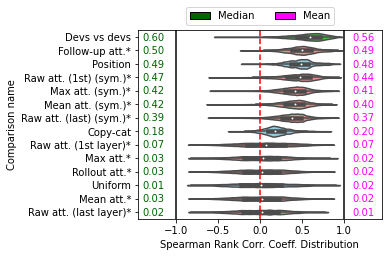

In [26]:
from matplotlib.patches import Patch

means = df_spearman.groupby('comparison_name')['spearman_res.corr'].mean()
medians = df_spearman.groupby('comparison_name')['spearman_res.corr'].median()

fig, ax = plt.subplots(figsize=(5.5, 3.7))

names_as_display_order = means.sort_values().index
# reverse the order
names_as_display_order = names_as_display_order[::-1]
palette = {
    "tl_spearman" + k: v for k, v in colors_mapping.items()}
nl_mapping = {
    "tl_spearman" + k: v for k, v in naming_mapping.items()}

sns.violinplot(
    data=df_spearman,
    x="spearman_res.corr",
    y="comparison_name",
    order=names_as_display_order,
    palette=palette,
    ax=ax
)
for i, name in enumerate(names_as_display_order):
    ax.text(
        -1.40, i + 0.25, f"{medians[name]:.2f}", color='darkgreen')
    ax.text(
        1.1, i + 0.25, f"{means[name]:.2f}", color='magenta')

# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in names_as_display_order])

#plt.setp(ax.collections, alpha=.3)
#plt.scatter(y=range(len(means)), x=means, color='red', marker='o')
#plt.scatter(y=range(len(medians)), x=medians, color='darkgreen', marker='X')
# vertical line on -1 and +1
ax.axvline(x=-1, color='black')
ax.axvline(x=1, color='black')
# red in zero
ax.axvline(x=0, color='red', linestyle='--')
ax.set_xlabel("Spearman Rank Corr. Coeff. Distribution")
ax.set_ylabel("Comparison name")
plt.xlim(-1.45, 1.45)

# add legend with magenta and green patches
legend_elements = [
    Patch(facecolor='darkgreen', edgecolor='black', label='Median'),
    Patch(facecolor='magenta', edgecolor='black', label='Mean'),]
# position the legend above outside the plot
ax.legend(
    handles=legend_elements, loc='upper center', 
    bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, f"tl_spearman_all_comparisons_{TARGET_MODEL}.pdf"))

In [27]:
df = df_target_model[
    (df_target_model['comparison_name'].str.contains('tl_top3')) &
    ~(df_target_model['comparison_name'].str.contains('pair')) & 
    ~(df_target_model['comparison_name'].str.contains('followup_max'))]
col_name = "top_3.value"
# remove invalid comparisons
df = df[df[col_name] != -1]
# convert col_name to string
df[col_name] = df[col_name].astype(int).astype(str)
# weight the datapoint for the time spent on the starting token
df = replicated_based_on_token_visibility(
    df=df,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)
# keep only those in the nl mapping
df = df[df['comparison_name'].isin([
    "tl_top3" + n for n in naming_mapping.keys()])]
df_top3 = df

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


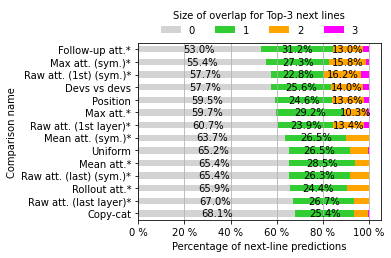

In [28]:
nl_mapping = {
    "tl_top3" + k: v for k, v in naming_mapping.items()}
# sort based on the percentage of zeros for each group
ascending_order = df_top3.groupby('comparison_name')['top_3.value'].value_counts(normalize=True).loc[:, '0'].sort_values().index
# reverse the order
ascending_order = ascending_order[::-1]
fig, ax = plot_100_perc_stacked_bar(
    df=df_top3,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=ascending_order,
    #group_order=sorted(names_as_display_order, reverse=True),
    n_cols_legend=4,
    # color balck, limegree, 
    fmt='{:.1%}',
    color=['lightgray', 'limegreen', 'orange', 'magenta'],
    legend_title='Size of overlap for Top-3 next lines'
)
# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in ascending_order
])
ax.set_xlabel("Percentage of next-line predictions")
ax.set_ylabel("Comparison name")
fig.set_size_inches(5.5, 3.7)
plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, f"tl_top3_all_comparisons_{TARGET_MODEL}.pdf"))

## 3.0 Specify Target Model

In [49]:
TARGET_MODEL = "incoder"

df_target_model = dict_df_cmparison_interaction_matrix[TARGET_MODEL]
df_tokens_w_time = dict_df_tokens_w_time[TARGET_MODEL]

## 3.1 Spearman Correlation


In [30]:
df = df_target_model[
    (df_target_model['comparison_name'].str.contains('tl_spearman')) &
    ~(df_target_model['comparison_name'].str.contains('pair')) & 
    ~(df_target_model['comparison_name'].str.contains('followup_max'))]

# drop all meaningless comparisons (the correlation was not defined)
df = df[df["spearman_res.corr"] != -1]

# augment the dataset with the time weights
df = replicated_based_on_token_visibility(
    df=df, 
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='spearman_res',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)

# keep only those in the nl mapping
df = df[df['comparison_name'].isin([
    "tl_spearman" + n for n in naming_mapping.keys()])]
df_spearman = df

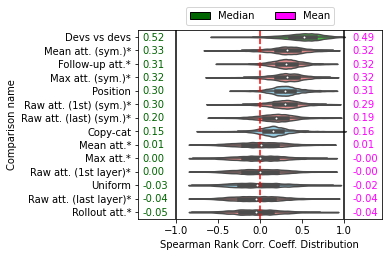

In [31]:
from matplotlib.patches import Patch

means = df_spearman.groupby('comparison_name')['spearman_res.corr'].mean()
medians = df_spearman.groupby('comparison_name')['spearman_res.corr'].median()

fig, ax = plt.subplots(figsize=(5.5, 3.7))

names_as_display_order = means.sort_values().index
# reverse the order
names_as_display_order = names_as_display_order[::-1]
palette = {
    "tl_spearman" + k: v for k, v in colors_mapping.items()}
nl_mapping = {
    "tl_spearman" + k: v for k, v in naming_mapping.items()}

sns.violinplot(
    data=df_spearman,
    x="spearman_res.corr",
    y="comparison_name",
    order=names_as_display_order,
    palette=palette,
    ax=ax
)
for i, name in enumerate(names_as_display_order):
    ax.text(
        -1.40, i + 0.25, f"{medians[name]:.2f}", color='darkgreen')
    ax.text(
        1.1, i + 0.25, f"{means[name]:.2f}", color='magenta')

# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in names_as_display_order])

#plt.setp(ax.collections, alpha=.3)
#plt.scatter(y=range(len(means)), x=means, color='red', marker='o')
#plt.scatter(y=range(len(medians)), x=medians, color='darkgreen', marker='X')
# vertical line on -1 and +1
ax.axvline(x=-1, color='black')
ax.axvline(x=1, color='black')
# red in zero
ax.axvline(x=0, color='red', linestyle='--')
ax.set_xlabel("Spearman Rank Corr. Coeff. Distribution")
ax.set_ylabel("Comparison name")
plt.xlim(-1.45, 1.45)

# add legend with magenta and green patches
legend_elements = [
    Patch(facecolor='darkgreen', edgecolor='black', label='Median'),
    Patch(facecolor='magenta', edgecolor='black', label='Mean'),]
# position the legend above outside the plot
ax.legend(
    handles=legend_elements, loc='upper center', 
    bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, f"tl_spearman_all_comparisons_{TARGET_MODEL}.pdf"))

## 3.2 Top-K

In [50]:
df = df_target_model[
    (df_target_model['comparison_name'].str.contains('tl_top3')) &
    ~(df_target_model['comparison_name'].str.contains('pair')) & 
    ~(df_target_model['comparison_name'].str.contains('followup_max'))]
col_name = "top_3.value"
# remove invalid comparisons
df = df[df[col_name] != -1]
# convert col_name to string
df[col_name] = df[col_name].astype(int).astype(str)
# weight the datapoint for the time spent on the starting token
df = replicated_based_on_token_visibility(
    df=df,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)
# keep only those in the nl mapping
df = df[df['comparison_name'].isin([
    "tl_top3" + n for n in naming_mapping.keys()])]
df_top3 = df

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


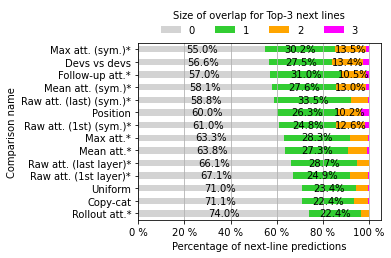

In [51]:
nl_mapping = {
    "tl_top3" + k: v for k, v in naming_mapping.items()}
# sort based on the percentage of zeros for each group
ascending_order = df_top3.groupby('comparison_name')['top_3.value'].value_counts(normalize=True).loc[:, '0'].sort_values().index
# reverse the order
ascending_order = ascending_order[::-1]
fig, ax = plot_100_perc_stacked_bar(
    df=df_top3,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=ascending_order,
    #group_order=sorted(names_as_display_order, reverse=True),
    n_cols_legend=4,
    # color balck, limegree, 
    fmt='{:.1%}',
    color=['lightgray', 'limegreen', 'orange', 'magenta'],
    legend_title='Size of overlap for Top-3 next lines'
)
# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in ascending_order
])
ax.set_xlabel("Percentage of next-line predictions")
ax.set_ylabel("Comparison name")
fig.set_size_inches(5.5, 3.7)
plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, f"tl_top3_all_comparisons_{TARGET_MODEL}.pdf"))

# CodeGen 6B

In [14]:
TARGET_MODEL = "codegen6B"

df_target_model = dict_df_cmparison_interaction_matrix[TARGET_MODEL]
df_tokens_w_time = dict_df_tokens_w_time[TARGET_MODEL]

In [15]:
df = df_target_model[
    (df_target_model['comparison_name'].str.contains('tl_spearman')) &
    ~(df_target_model['comparison_name'].str.contains('pair')) & 
    ~(df_target_model['comparison_name'].str.contains('followup_max'))]

# drop all meaningless comparisons (the correlation was not defined)
df = df[df["spearman_res.corr"] != -1]

# augment the dataset with the time weights
df = replicated_based_on_token_visibility(
    df=df, 
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='spearman_res',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)

# keep only those in the nl mapping
df = df[df['comparison_name'].isin([
    "tl_spearman" + n for n in naming_mapping.keys()])]
df_spearman = df

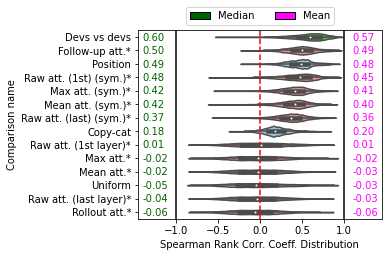

In [16]:
from matplotlib.patches import Patch

means = df_spearman.groupby('comparison_name')['spearman_res.corr'].mean()
medians = df_spearman.groupby('comparison_name')['spearman_res.corr'].median()

fig, ax = plt.subplots(figsize=(5.5, 3.7))

names_as_display_order = means.sort_values().index
# reverse the order
names_as_display_order = names_as_display_order[::-1]
palette = {
    "tl_spearman" + k: v for k, v in colors_mapping.items()}
nl_mapping = {
    "tl_spearman" + k: v for k, v in naming_mapping.items()}

sns.violinplot(
    data=df_spearman,
    x="spearman_res.corr",
    y="comparison_name",
    order=names_as_display_order,
    palette=palette,
    ax=ax
)
for i, name in enumerate(names_as_display_order):
    ax.text(
        -1.40, i + 0.25, f"{medians[name]:.2f}", color='darkgreen')
    ax.text(
        1.1, i + 0.25, f"{means[name]:.2f}", color='magenta')

# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in names_as_display_order])

#plt.setp(ax.collections, alpha=.3)
#plt.scatter(y=range(len(means)), x=means, color='red', marker='o')
#plt.scatter(y=range(len(medians)), x=medians, color='darkgreen', marker='X')
# vertical line on -1 and +1
ax.axvline(x=-1, color='black')
ax.axvline(x=1, color='black')
# red in zero
ax.axvline(x=0, color='red', linestyle='--')
ax.set_xlabel("Spearman Rank Corr. Coeff. Distribution")
ax.set_ylabel("Comparison name")
plt.xlim(-1.45, 1.45)

# add legend with magenta and green patches
legend_elements = [
    Patch(facecolor='darkgreen', edgecolor='black', label='Median'),
    Patch(facecolor='magenta', edgecolor='black', label='Mean'),]
# position the legend above outside the plot
ax.legend(
    handles=legend_elements, loc='upper center', 
    bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, f"tl_spearman_all_comparisons_{TARGET_MODEL}.pdf"))

In [17]:
df = df_target_model[
    (df_target_model['comparison_name'].str.contains('tl_top3')) &
    ~(df_target_model['comparison_name'].str.contains('pair')) & 
    ~(df_target_model['comparison_name'].str.contains('followup_max'))]
col_name = "top_3.value"
# remove invalid comparisons
df = df[df[col_name] != -1]
# convert col_name to string
df[col_name] = df[col_name].astype(int).astype(str)
# weight the datapoint for the time spent on the starting token
df = replicated_based_on_token_visibility(
    df=df,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)
# keep only those in the nl mapping
df = df[df['comparison_name'].isin([
    "tl_top3" + n for n in naming_mapping.keys()])]
df_top3 = df

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


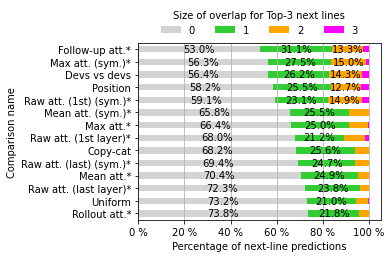

In [18]:
nl_mapping = {
    "tl_top3" + k: v for k, v in naming_mapping.items()}
# sort based on the percentage of zeros for each group
ascending_order = df_top3.groupby('comparison_name')['top_3.value'].value_counts(normalize=True).loc[:, '0'].sort_values().index
# reverse the order
ascending_order = ascending_order[::-1]
fig, ax = plot_100_perc_stacked_bar(
    df=df_top3,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=ascending_order,
    #group_order=sorted(names_as_display_order, reverse=True),
    n_cols_legend=4,
    # color balck, limegree, 
    fmt='{:.1%}',
    color=['lightgray', 'limegreen', 'orange', 'magenta'],
    legend_title='Size of overlap for Top-3 next lines'
)
# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in ascending_order
])
ax.set_xlabel("Percentage of next-line predictions")
ax.set_ylabel("Comparison name")
fig.set_size_inches(5.5, 3.7)
plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, f"tl_top3_all_comparisons_{TARGET_MODEL}.pdf"))

## GPTj

In [52]:
TARGET_MODEL = "gptj"

df_target_model = dict_df_cmparison_interaction_matrix[TARGET_MODEL]
df_tokens_w_time = dict_df_tokens_w_time[TARGET_MODEL]

In [35]:
df = df_target_model[
    (df_target_model['comparison_name'].str.contains('tl_spearman')) &
    ~(df_target_model['comparison_name'].str.contains('pair')) & 
    ~(df_target_model['comparison_name'].str.contains('followup_max'))]

# drop all meaningless comparisons (the correlation was not defined)
df = df[df["spearman_res.corr"] != -1]

# augment the dataset with the time weights
df = replicated_based_on_token_visibility(
    df=df, 
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='spearman_res',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)

# keep only those in the nl mapping
df = df[df['comparison_name'].isin([
    "tl_spearman" + n for n in naming_mapping.keys()])]
df_spearman = df

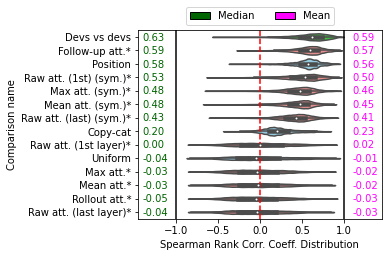

In [36]:
from matplotlib.patches import Patch

means = df_spearman.groupby('comparison_name')['spearman_res.corr'].mean()
medians = df_spearman.groupby('comparison_name')['spearman_res.corr'].median()

fig, ax = plt.subplots(figsize=(5.5, 3.7))

names_as_display_order = means.sort_values().index
# reverse the order
names_as_display_order = names_as_display_order[::-1]
palette = {
    "tl_spearman" + k: v for k, v in colors_mapping.items()}
nl_mapping = {
    "tl_spearman" + k: v for k, v in naming_mapping.items()}

sns.violinplot(
    data=df_spearman,
    x="spearman_res.corr",
    y="comparison_name",
    order=names_as_display_order,
    palette=palette,
    ax=ax
)
for i, name in enumerate(names_as_display_order):
    ax.text(
        -1.40, i + 0.25, f"{medians[name]:.2f}", color='darkgreen')
    ax.text(
        1.1, i + 0.25, f"{means[name]:.2f}", color='magenta')

# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in names_as_display_order])

#plt.setp(ax.collections, alpha=.3)
#plt.scatter(y=range(len(means)), x=means, color='red', marker='o')
#plt.scatter(y=range(len(medians)), x=medians, color='darkgreen', marker='X')
# vertical line on -1 and +1
ax.axvline(x=-1, color='black')
ax.axvline(x=1, color='black')
# red in zero
ax.axvline(x=0, color='red', linestyle='--')
ax.set_xlabel("Spearman Rank Corr. Coeff. Distribution")
ax.set_ylabel("Comparison name")
plt.xlim(-1.45, 1.45)

# add legend with magenta and green patches
legend_elements = [
    Patch(facecolor='darkgreen', edgecolor='black', label='Median'),
    Patch(facecolor='magenta', edgecolor='black', label='Mean'),]
# position the legend above outside the plot
ax.legend(
    handles=legend_elements, loc='upper center', 
    bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, f"tl_spearman_all_comparisons_{TARGET_MODEL}.pdf"))

In [53]:
df = df_target_model[
    (df_target_model['comparison_name'].str.contains('tl_top3')) &
    ~(df_target_model['comparison_name'].str.contains('pair')) & 
    ~(df_target_model['comparison_name'].str.contains('followup_max'))]
col_name = "top_3.value"
# remove invalid comparisons
df = df[df[col_name] != -1]
# convert col_name to string
df[col_name] = df[col_name].astype(int).astype(str)
# weight the datapoint for the time spent on the starting token
df = replicated_based_on_token_visibility(
    df=df,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)
# keep only those in the nl mapping
df = df[df['comparison_name'].isin([
    "tl_top3" + n for n in naming_mapping.keys()])]
df_top3 = df

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


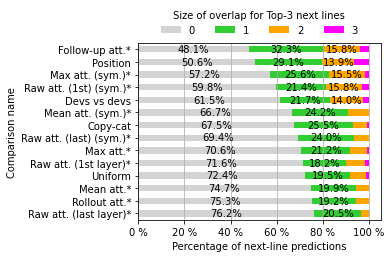

In [54]:
nl_mapping = {
    "tl_top3" + k: v for k, v in naming_mapping.items()}
# sort based on the percentage of zeros for each group
ascending_order = df_top3.groupby('comparison_name')['top_3.value'].value_counts(normalize=True).loc[:, '0'].sort_values().index
# reverse the order
ascending_order = ascending_order[::-1]
fig, ax = plot_100_perc_stacked_bar(
    df=df_top3,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=ascending_order,
    #group_order=sorted(names_as_display_order, reverse=True),
    n_cols_legend=4,
    # color balck, limegree, 
    fmt='{:.1%}',
    color=['lightgray', 'limegreen', 'orange', 'magenta'],
    legend_title='Size of overlap for Top-3 next lines'
)
# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in ascending_order
])
ax.set_xlabel("Percentage of next-line predictions")
ax.set_ylabel("Comparison name")
fig.set_size_inches(5.5, 3.7)
plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, f"tl_top3_all_comparisons_{TARGET_MODEL}.pdf"))

# 4. Ablation Study

In [20]:
layer_naming_mapping = {
 '_divide_all_dist_followup_layer_pair_0': 'Layer 0-1',
 '_divide_all_dist_followup_layer_pair_3': 'Layer 3-4',
 '_divide_all_dist_followup_layer_pair_6': 'Layer 6-7',
 '_divide_all_dist_followup_layer_pair_9': 'Layer 9-10',
 '_divide_all_dist_followup_layer_pair_12': 'Layer 12-13',
 '_divide_all_dist_followup_layer_pair_15': 'Layer 15-16',
 '_divide_all_dist_followup_layer_pair_18': 'Layer 18-19',
 '_divide_all_dist_followup_layer_pair_21': 'Layer 21-22',
 '_divide_all_dist_followup_layer_pair_24': 'Layer 24-25',
 '_divide_all_dist_followup_layer_pair_27': 'Layer 27-28',
 '_divide_all_dist_followup_layer_pair_30': 'Layer 30-31',
 '_divide_all_dist_followup_layer_pair_32': 'Layer 32-33',
 '_divide_all_dist_followup': 'All layers',
}
n_generated_tokens_naming_mapping = {
 '_divide_all_dist_followup_max_10_all_layers': '10 tokens',
 '_divide_all_dist_followup_max_50_all_layers': '50 tokens',
 '_divide_all_dist_followup': '100 tokens',
}

## 4.1 Layer analysis

In [21]:
df = df_codegen[
    (df_codegen['comparison_name'].str.contains('followup')) &
    ~(df_codegen['comparison_name'].str.contains('followup_max'))]
col_name = "top_3.value"
# remove invalid comparisons
df = df[df[col_name] != -1]
# drop nan values
df = df.dropna(subset=[col_name])
# convert col_name to string
df[col_name] = df[col_name].astype(int).astype(str)
# weight the datapoint for the time spent on the starting token
df = replicated_based_on_token_visibility(
    df=df,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)
df_top3_layers = df

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


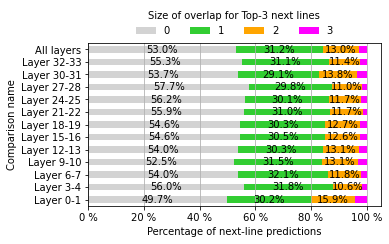

In [22]:
nl_mapping = {
    "tl_top3" + k: v for k, v in layer_naming_mapping.items()}
definition_order = ["tl_top3" + k for k, v in layer_naming_mapping.items()]
fig, ax = plot_100_perc_stacked_bar(
    df=df_top3_layers,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=definition_order,
    #group_order=sorted(names_as_display_order, reverse=True),
    n_cols_legend=4,
    # color balck, limegree, 
    fmt='{:.1%}',
    color=['lightgray', 'limegreen', 'orange', 'magenta'],
    legend_title='Size of overlap for Top-3 next lines'
)
# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in definition_order
])
ax.set_xlabel("Percentage of next-line predictions")
ax.set_ylabel("Comparison name")
fig.set_size_inches(5.5, 3.5)
plt.tight_layout()
fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, "tl_top3_abl_layers.pdf"))

## 4.2 No. generated tokens

In [23]:
df = df_codegen[
    (df_codegen['comparison_name'].str.contains('followup')) &
    ~(df_codegen['comparison_name'].str.contains('pair'))]
col_name = "top_3.value"
# remove invalid comparisons
df = df[df[col_name] != -1]
# drop nan values
df = df.dropna(subset=[col_name])
# convert col_name to string
df[col_name] = df[col_name].astype(int).astype(str)
# weight the datapoint for the time spent on the starting token
df = replicated_based_on_token_visibility(
    df=df,
    df_tokens_w_time=df_tokens_w_time.copy(), 
    short_col_name='top_3',
    weight_column_name='n_replicas_abs')
df = df.reset_index(drop=True)
df_top3_tokens = df

/home/eaftan/copilot-attention/attwizard/visualizer/eda.py:275: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


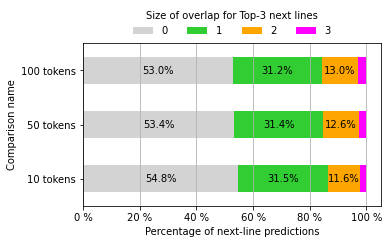

In [24]:
nl_mapping = {
    "tl_top3" + k: v for k, v in n_generated_tokens_naming_mapping.items()}
definition_order = ["tl_top3" + k for k, v in n_generated_tokens_naming_mapping.items()]
fig, ax = plot_100_perc_stacked_bar(
    df=df_top3_tokens,
    col_name_group="comparison_name",
    col_name_category_in_group=col_name,
    direction='horizontal',
    group_order=definition_order,
    #group_order=sorted(names_as_display_order, reverse=True),
    n_cols_legend=4,
    # color balck, limegree, 
    fmt='{:.1%}',
    color=['lightgray', 'limegreen', 'orange', 'magenta'],
    legend_title='Size of overlap for Top-3 next lines'
)
# replace the labels with the natural language names
ax.set_yticklabels([
    nl_mapping[n] + '*'
    if "att." in nl_mapping[n] else nl_mapping[n]
    for n in definition_order
])
ax.set_xlabel("Percentage of next-line predictions")
ax.set_ylabel("Comparison name")
fig.set_size_inches(5.5, 3.5)
plt.tight_layout()

fig.savefig(
    os.path.join(OUT_PAPER_FOLDER, "tl_top3_abl_tokens.pdf"))

In [26]:
print("stop. Results repreduced and paper images saved: " + OUT_PAPER_FOLDER)

stop. Results repreduced and paper images saved: ../data/paper_figures
